In [1]:
# TODO: add visualization 
# TODO: add ffmpeg https://www.kaggle.com/code/josecarmona/ffmpeg-python-example-to-extract-audio-from-mp4

In [2]:
#!pip3 install torch torchvision torchaudio
#!pip3 install tqdm
# !pip install ffmpeg-python

In [1]:
import cv2
import os
import csv
import pandas as pd
import numpy as np
import math
import torch
import subprocess

import ffmpeg
from ffmpeg import Error

import IPython.display

from tqdm import tqdm

/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

print(torch.cuda.is_available())
torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 3090 Ti'

In [3]:
#!python3 -m pip --version

In [4]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [5]:
class VideoCamera(object):
    def __init__(self, path_video='', path_save_ims_txt='', path_save_df='', multiple=10, plot_markers=False):
        self.path_video = path_video
        self.path_save_ims_txt = path_save_ims_txt
        self.path_save_df = path_save_df
        self.multiple = multiple # шаг прореживания кадров
        self.c_fr = 1 # счетчик для кадров
        self.video = None
        self.total_frames = None
        self.vad_model, self.vad_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                                   model='silero_vad',
                                                   force_reload=False)
        self.get_speech_timestamps, _, self.read_audio, _, _ = self.vad_utils
        self.plot_markers=plot_markers
        self.idx_to_coors = {}

    def __del__(self):
        self.video.release()
        
    def norm_coordinates(self, normalized_x, normalized_y, image_width, image_height):

        x_px = min(math.floor(normalized_x * image_width), image_width - 1)
        y_px = min(math.floor(normalized_y * image_height), image_height - 1)

        return x_px, y_px

    def get_box(self, fl, w, h):
        for idx, landmark in enumerate(fl.landmark):  # TODO: Why is it?
            if ((landmark.HasField('visibility') and
                 landmark.visibility < _VISIBILITY_THRESHOLD) or
                (landmark.HasField('presence') and
                 landmark.presence < _PRESENCE_THRESHOLD)):
                continue
            landmark_px = self.norm_coordinates(landmark.x, landmark.y, w, h)

            if landmark_px:
                """
                Записать в словарь idx_to_coors значения координаты landmark_px по нужному ключу idx
                """
                self.idx_to_coors[idx] = landmark_px
        """
        Найти минимальные и максимальные значения координат x и y.
        """
        ys = [v[1] for _, v in self.idx_to_coors.items()]
        xs = [v[0] for _, v in self.idx_to_coors.items()]
        x_min = min(xs)
        y_min = min(ys)
        x_max = max(xs)
        y_max = max(ys)
        
        """
        Обновить минимальные и максимальные значения координат x и y по принципу:
        1) если x_min и/или y_min меньше 0, то x_min и/или y_min равны 0
        2) если x_max и y_max больше w и h, то установить значения x_max=w-1, y_max=h-1
        """
        (x_min, y_min) = max(x_min, 0), max(y_min, 0)
        (x_max, y_max) = min(x_max, w - 1), min(y_max, h - 1)
        
        return x_min, y_min, x_max, y_max
        
    def norm_box(self, size=None, box=None):
        """
        Написать метод нормализации координат ограничительных рамок лица. Входные переменные метода:
        - size=(w,h), где w - ширина кадра, h высота кадра
        - box = x_min, y_min, x_max, y_max
        
        1) Нормализовать значения dw, dh, по принципу:   
            - 1/size[0]
            - 1/size[0]
        2) Найти значения центральных координат сx и сy для значений (x_min, x_max) и (y_min, y_max) учетом вычета 1 из обоих центральных координат.
        3) Найти ширину fw и высоту fh лица используя координаты (x_min, x_max) и (y_min, y_max).
        4) Нормализовать значения сx и fw на величину dw, сy и fh на величину dh путем перемножения.
        """
        x_min, y_min, x_max, y_max = box
        w, h = size

        dw = 1 / w
        dh = 1 / h

        cx = (x_min + x_max) / 2 - 1
        cy = (y_min + y_max) / 2 - 1

        fw = x_max - x_min
        fh = y_max - y_min

        cx = cx * dw
        cy = cy * dh
        fw = fw * dw
        fh = fh * dh
        return [cx,cy,fw,fh]
    
    def extract_audio(self, filename):
        try:
            out, err = (
                ffmpeg
                .input(filename, format='flv')
                .output('-', vn=None, format='wav', acodec='pcm_s16le', ac=2, ar='16000')
                .run(capture_stdout=True, capture_stderr=True)
            )
        except Error as err:
            print(err.stderr)
            raise

        return out
    
    def get_timestamps(self, ffmpeg_cmd=True):
        """
        Написать метод, который работает со свойствами класса VideoCamera:
        - self.path_video, 
        - self.read_audio, 
        - self.get_speech_timestamps,
        - self.vad_model.
        Возвращает:
        1) время начала речи в секундах;
        2) время конца речи в секундах.
        
        Для определения границ речи воспользуемся silero. 
        Silero принимает на вход разрешения файл разрешения wav.
        1) Необходимо конвертнуть видео файл формата mp4 в аудиофайл формата wav, выполнив команду:
           os.system("ffmpeg -i path_video -vn -acodec pcm_s16le -ar 16000 -ac 2 save_path_audio")
           где path_video=self.path_video, save_path_audio - путь к для сохранения аудио файла.
        2) Воспользуйтесь свойством класса self.read_audio(save_path_audio, sampling_rate=16000), чтобы считать wav файл.
        3) Удалить wav файл с помощью os.remove(), можно конечно не удалять wav файл, но он вам больше не понадобится.
        3) Воспользуйтесь свойством класса self.get_speech_timestamps(wav, self.vad_model, sampling_rate=16000), чтобы получить границы речи.
        4) Переведите границы речи из отсчетов в секунды.
        
        Внимание!!!
        
        Silero может выдавать список словарей с несколькими границами речи, 
        поэтому рекомендуется использовать начало речи нулевого элемента по ключу 'start',
        конец речи -1 элемента по ключу 'end'.
        """
        
        if ffmpeg_cmd:
            save_path_audio = 'tmp_wav.wav'
            os.system(f"ffmpeg -i {self.path_video} -vn -acodec pcm_s16le -ar 16000 -ac 2 {save_path_audio}")
            wav = self.read_audio(save_path_audio, sampling_rate=16000)
            os.remove(save_path_audio)
        else:
            wav = torch.tensor(np.frombuffer(self.extract_audio(self.path_video, dtype=np.float16))) #TODO: fix bugs
        
        speech_timestamps = self.get_speech_timestamps(wav, self.vad_model, sampling_rate=16000)
        if len(speech_timestamps) > 1: # если вад нашел границы речи
            start = speech_timestamps[0]['start'] / 16000 # работаем с speech_timestamps
            end = speech_timestamps[0]['end'] / 16000 # работаем с speech_timestamps
        else: # в противном случае
            start, end = 0, len(wav) / 16000  # TODO: bug -> return frames
        return start, end
   
    def get_id_cl(self):
        """
        Написать метод, который работает со свойством self.path_video класса VideoCamera.
        Возвращает:
        1) имя видеофайла (n_v) без расширения, например 1010_DFA_ANG_XX;
        2) индекс эмоции (id_cl) 
        
        Внимание!!! 
        
        Имя каждого файла зашифровано. Пример, расшифровки для 1010_DFA_ANG_XX.flv.
        
        1010 - уникальный номер актера.
        DFA - произносимая фраза.
        ANG - имитируемая эмоция.
        XX - интенсивность эмоции
        
        Вам понадобятся знания только об унимальном номере актера и имитируемая эмоция.
        Всего 6 эмоций:
        - Anger (ANG) - присвоить уникальный номер класса эмоции 0
        - Disgust (DIS) - присвоить уникальный номер класса эмоции 1
        - Fear (FEA) - присвоить уникальный номер класса эмоции 2
        - Happy/Joy (HAP) - присвоить уникальный номер класса эмоции 3
        - Neutral (NEU) - присвоить уникальный номер класса эмоции 4
        - Sad (SAD) - присвоить уникальный номер класса эмоции 5
        
        1) Необходимо получить имя файла без расширения.
        2) Преобразовать название эмоции в его индекс, например ANG - 0.
        """
        em2id = {
            'ANG': 0, 
            'DIS': 1, 
            'FEA': 2, 
            'HAP': 3, 
            'NEU': 4, 
            'SAD': 5,
        }
        n_v = self.path_video.split('/')[-1].split('.')[0] # TODO: use os.path
        id_cl = em2id[n_v.split('_')[-2]]
        return n_v, id_cl
    
    def makedirs(self, n_v):
        """
        Написать метод, который проверяет, существует ли папка для сохранения кадров и txt файлов.
        При отсутствии папки создать ее. Использовать библиотеку os.
        Путь для сохранения должен состоять из  self.path_save_ims_txt, n_v.
        Пример пути для сохранения кадров и txt файлов: .\CREMA_D_img_txt\1010_DFA_ANG_XX\.
        
        Работает со:
        1) свойством self.path_save_ims_txt
        Принимает на вход:
        1) имя видеофайла (n_v).
        Возвращает:
        1) путь (c_path) для сохранения кадров и txt файлов
        """
        c_path = os.path.join(self.path_save_ims_txt, n_v)
        if not os.path.exists(c_path):
            os.makedirs(c_path)
        return c_path
            
    def save_txt(self, c_path, n_img, line_need):
        """
        Написать метод для сохранения line_need в 1 txt файл.
        Пример пути для сохранения txt: .\CREMA_D_img_txt\1010_DFA_ANG_XX\000001.txt
        
        Принимает на вход:
        1) путь (c_path) для сохранения кадров и txt файлов
        2) текущее имя кадра (n_img) 
        3) кортеж (line_need)
        Возвращает:
        1) Ничего
        """
        with open(os.path.join(c_path, n_img) + '.txt', 'w') as f:
            # преобразовать line_need, пример:
            # из (0, 0.525, 0.451172, 0.3375, 0.511719)
            # в '0 0.525 0.451172 0.3375 0.511719\n'
            new_line = ' '.join([*map(str, (line_need))])
            f.write(new_line)
            
    def save_img(self, c_path, n_img):
        
        """
        Написать метод для сохранения кадров.
        Пример пути для сохранения кадров: .\CREMA_D_img_txt\1010_DFA_ANG_XX\000010.jpg
        
        Работает со:
        1) свойством self.fr
        Принимает на вход:
        1) путь (c_path) для сохранения кадров и txt файлов
        2) текущее имя кадра (n_img) 
        Возвращает:
        1) Ничего
        """
        cv2.imwrite(os.path.join(c_path, n_img) +'.jpg', self.fr)
        
        if self.plot_markers:
            for cord in self.idx_to_coors.values():
                cv2.putText(self.fr, '.', cord, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 2)
            
            cx, cy, fw, fh = self.box_
            w, h = self.w, self.h
            cx, cy = int(cx * w), int(cy * h)
            fw, fh = int(fw * w), int(h * fh)
            cv2.putText(self.fr, '.', [cx, cy], cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.rectangle(self.fr, [cx - fw // 2, cy - fh // 2], [cx + fw // 2, cy + fh // 2], (0, 0, 255), 2)
            
            cv2.imwrite(os.path.join(c_path, n_img) + '.marker.jpg', self.fr)
            
        
    def create_df(self):
        """
        Написать метод проверки существует ли датафрейм с метаданными видео
        и при отсутствии датафрейма создать его.
        Названия столбцов датафрейма:
        name_video - имя файла без расширения
        id_classes - индекс эмоции, представленной на видео
        speech_duration - продолжительность речи
        
        Работает со:
        1) свойством self.path_save_df
        Принимает на вход:
        1) Ничего
        Возвращает:
        1) Ничего
        """
        if not os.path.exists(self.path_save_df):
            # создать пустой датафрейм c заданными наименованиями столбцов
            df = pd.DataFrame(columns=['name_video', 'id_classes', 'speech_duration'])
            # сохранить датафрейм
            df.to_csv(self.path_save_df, index=False)
    
    def get_frame(self):
        self.video = cv2.VideoCapture(self.path_video)  
        fps = np.round(self.video.get(cv2.CAP_PROP_FPS)) # получаем информацио о fps видео
        w = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH)) # получаем информацио о ширине кадра
        h = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT)) # получаем информацио о высоте кадра
        self.total_frame = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT)) # получаем информацию об общем количестве кадров
        
        self.w = w
        self.h = h
        
        """
        1. Написать и вызвать метод self.get_timestamps для получения начала и конца речи с помощью silero
        start, end = self.get_timestamps()
        """
        start, end = self.get_timestamps()
        """
        2. Перевести время с секунд в кадры. Сформировать список need_frames нужных прореженных кадров, 
        используя start, end, self.multiple. 
        """
        need_frames = [frame for frame in range(int(fps * start), int(fps * end) + 1, self.multiple)]
        """
        3. Написать и вызвать метод self.get_id_cl()
        """
        n_v, id_cl = self.get_id_cl()
        
        with mp_face_mesh.FaceMesh(
                max_num_faces=1,
                refine_landmarks=False,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as face_mesh:
        
            while True:
                _, self.fr = self.video.read()
                if self.fr is None: break
                    
                """
                4. Написать условие: если текущий кадр self.c_fr есть в списке need_frames, то выполнить обнаружение лица
                """
                if self.c_fr in need_frames: 
                    
                    n_img = str(self.c_fr).zfill(6)

                    self.fr.flags.writeable = False
                    self.fr = cv2.cvtColor(self.fr, cv2.COLOR_BGR2RGB)
                    results = face_mesh.process(self.fr)

                    self.fr.flags.writeable = True
                    self.fr = cv2.cvtColor(self.fr, cv2.COLOR_RGB2BGR)

                    if results.multi_face_landmarks:
                        for fl in results.multi_face_landmarks:
                            box = self.get_box(fl, w, h) # Дописать код
                            newbox = self.norm_box(size=(w, h), box=box) # Дописать код
                            line_need = (id_cl, *newbox)
                            
                            self.box_ = newbox
                            
                            """
                            5. Написать и вызвать метод self.mekedirs() для сознания пути сохранения изображений и текстовых файлов.
                            """
                            c_path = self.makedirs(n_v)
                            """
                            6. Написать и вызвать метод self.save_txt() для сохранения текстовых файлов.
                            """
                            self.save_txt(c_path, n_img, line_need)
                            """
                            7. Написать и вызвать метод self.save_img() для сохранения изображений.
                            """
                            self.save_img(c_path, n_img)
                self.c_fr += 1
                
        """
        8. Написать и вызвать метод self.create_df() для создания или проверки существования датафрейма с метаданными
        """        
                
        self.create_df()
        
        """
        9. Сохранить метаданные о видео:
        - name_video,
        - id_classes,
        - speech_duration (указать продолжительность речи, использовать значения start и end)
        """  
        with open(self.path_save_df, 'a+', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow([n_v, id_cl, end - start])

In [10]:
path_dataset = '../sambashare/ITMO_LABS/ML/Video'
valid_files = ['1001_DFA_ANG_XX.flv']
path_save_img_txt_valid = '../sambashare/ITMO_LABS/ML/valid_prog/'
path_save_df_valid = '../sambashare/ITMO_LABS/ML/valid_prog/df_recort.csv'
plot_markers = True

for file in tqdm(valid_files):
    detect = VideoCamera(path_video=os.path.join(path_dataset, file), 
                         path_save_ims_txt=path_save_img_txt_valid, 
                         path_save_df=path_save_df_valid, multiple=10, plot_markers=plot_markers)
    detect.get_frame()
    IPython.display.clear_output(wait=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


0 0.44895833333333335 0.4027777777777778 0.19375 0.31666666666666665


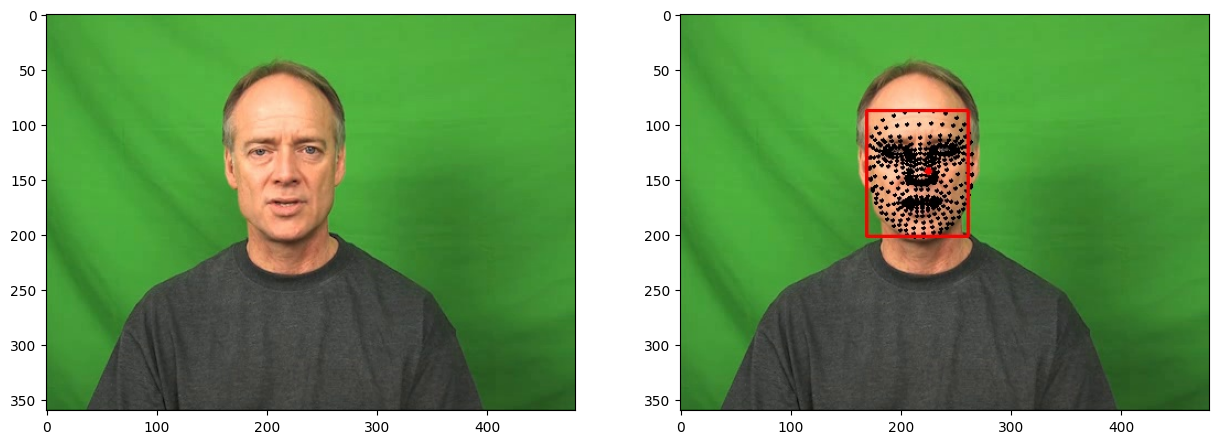

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

_, axs = plt.subplots(1, 2, figsize=(15, 15))
img1 = np.asarray(Image.open('../sambashare/ITMO_LABS/ML/valid_prog/1001_DFA_ANG_XX/000010.marker.jpg'))
img2 = np.asarray(Image.open('../sambashare/ITMO_LABS/ML/valid_prog/1001_DFA_ANG_XX/000010.jpg'))
axs[0].imshow(img2)
axs[1].imshow(img1)
with open('../sambashare/ITMO_LABS/ML/valid_prog/1001_DFA_ANG_XX/000010.txt') as file:
    print(file.read())

In [6]:
path_dataset = '../sambashare/ITMO_LABS/ML/Video' # Пропишите путь к видеоданным
path_save_img_txt_train = '../sambashare/ITMO_LABS/ML/train/' # Пропишите путь к сохранению обучающий данных
path_save_img_txt_test = '../sambashare/ITMO_LABS/ML/test/' # Пропишите путь к сохранению тестовых данных
path_save_df = '../sambashare/ITMO_LABS/ML/df_recort.csv' # Пропишите путь к сохранению методанных о видео

files = os.listdir(path_dataset) #Используйте os.listdir() для считывания всех видеоданных

"""
1) Отберите спикеров для обучения и тестирования
    Имя каждого файла зашифровано. Пример, расшифровки для 1010_DFA_ANG_XX.flv.
            
    1010 - уникальный номер актера.
    DFA - произносимая фраза.
    ANG - имитируемая эмоция.
    XX - интенсивность эмоции
    
    Отбираем спикеров по уникальному номеру актера. 
"""
None

In [7]:
speaker_ids = [id for id in range(1036, 1041 + 1)]

train_files = [file for file in files if int(file.split('_')[0]) not in speaker_ids]
test_files = [file for file in files if int(file.split('_')[0]) in speaker_ids]

In [8]:
for file in tqdm(train_files):
    detect = VideoCamera(path_video=os.path.join(path_dataset, file), 
                         path_save_ims_txt=path_save_img_txt_train, 
                         path_save_df=path_save_df, multiple=10)
    detect.get_frame()
    IPython.display.clear_output(wait=True)

100%|█████████████████████████████████████████████████████████████████████████████| 6948/6948 [4:24:25<00:00,  2.28s/it]


In [9]:
for file in tqdm(test_files):
    detect = VideoCamera(path_video=os.path.join(path_dataset, file), 
                         path_save_ims_txt=path_save_img_txt_test, 
                         path_save_df=path_save_df, multiple=10)
    detect.get_frame()
    IPython.display.clear_output(wait=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 492/492 [18:41<00:00,  2.28s/it]


In [14]:
em2id = {
    'ANG': 0, 
    'DIS': 1, 
    'FEA': 2, 
    'HAP': 3, 
    'NEU': 4, 
    'SAD': 5,
}
df = pd.read_csv(path_save_df)
df.id_classes = df.id_classes.map({v: k for k, v in em2id.items()})
df.groupby(by='id_classes')['speech_duration'].mean()

id_classes
ANG    2.553354
DIS    2.657400
FEA    2.512390
HAP    2.374039
NEU    2.441216
SAD    2.565046
Name: speech_duration, dtype: float64

In [ ]:
|